In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from dask.distributed import Client
import distributed

from condor_utils import make_htcondor_cluster
from dask.distributed import Client, progress
#from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

import utils
import glob
import uproot4
import awkward1 as ak
#from yahist import Hist1D ## WTF this is still missing...
#from yahist import Hist2D

import matplotlib.pyplot as plt

#import uproot_methods

utils.bokeh_output_notebook()


Loading BokehJS ...

In [2]:
cluster = make_htcondor_cluster(local=False, dashboard_address=13349)
cluster

In [3]:
cluster.scale(20)

In [4]:
c = Client(cluster)
c

Client Scheduler: tcp://169.228.130.5:4006 Dashboard: http://169.228.130.5:13349/status,Cluster Workers: 17 Cores: 17 Memory: 68.00 GB


In [21]:
%%time

fileset = {
    'DY': [
        'root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv6/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/40000/E27D1CD7-7D2D-A947-8B81-DBCC4982246D.root',
        'root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv6/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/40000/28D1E5F8-1892-E74D-A252-F0F4EBD136BC.root',
    ],
    'TT': [
        'root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv6/TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/60000/AF2405EC-2325-3A44-B7C2-AE7616557973.root',
    ],
}


CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 24.8 µs


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

#import uproot
import uproot_methods
import awkward
from awkward import JaggedArray

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import LazyDataFrame
import coffea.processor as processor

class SimpleProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        pt_axis = hist.Bin("pt", r"$p_{T,\mu}$ [GeV]", 1000, 0, 500)
        
        self._accumulator = processor.dict_accumulator({
            'MET_pt': hist.Hist("Counts", dataset_axis, pt_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            'workers': processor.set_accumulator(),
            'entries': processor.defaultdict_accumulator(int),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        try:
            from dask.distributed import get_worker
            output["workers"].add(get_worker().name)
        except:
            pass
    
        
        dataset = df['dataset']
        # preselection of events
        selection = df['nMuon']>=1

        dataset = df["dataset"]

        output['entries']['all'] += len(df['MET_pt'])
        
        # And fill the histograms
        output['MET_pt'].fill(dataset=dataset, pt=df["MET_pt"][selection].flatten(), weight=df['genWeight'][selection])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [37]:
import time

tstart = time.time()

exe_args = {
        'client': c,
        #'savemetrics': True,
    }

output = processor.run_uproot_job(fileset,
                                treename = 'Events',
                                processor_instance = SimpleProcessor(),
                                #executor=processor.futures_executor,
                                #executor_args={'workers': 4, 'function_args': {'flatten': False}},
                                chunksize=500000,
                                executor = processor.dask_executor,
                                executor_args = exe_args
                                )

elapsed = time.time() - tstart


In [41]:
print("{nworkers} total workers".format(nworkers=len(output["workers"])))
print("{events:g} events in {dt:.1f}s @ {rate:.1f}kHz, including chunking".format(
    events=output["entries"]["all"],
    dt=elapsed,
    rate=output["entries"]["all"]/elapsed/1e3,
))

## This does not yet work because metrics fail...
#print("Event rate per worker, excluding chunking and file/tree open: {rate:.1f}kHz".format(
#    rate=output[1]["entries"].value/output[1]["processtime"].value/1e3,
#))



10 total workers
4.84564e+06 events in 5.0s @ 976.4kHz, including chunking


In [38]:
output

{'MET_pt': <Hist (dataset,pt) instance at 0x7ff034b23cd0>,
 'cutflow': defaultdict_accumulator(int, {}),
 'workers': {0, 3, 4, 8, 9, 10, 13, 16, 18, 19},
 'entries': defaultdict_accumulator(int, {'all': 4845641})}

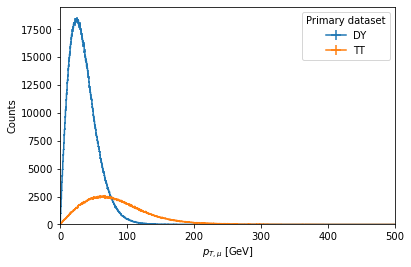

In [40]:
histogram = output['MET_pt']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)